In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
from quspin.operators import quantum_LinearOperator
from quspin.operators import quantum_operator
plt.rcParams['figure.figsize'] = [10, 8]
import matplotlib.ticker as ticker

In [20]:
def simulate(Tf, N, ein, m, Tsteps):

    PBC = True
    T = Tf/m
    dt = T/Tsteps
    times = np.arange(0,T,dt)

    g = np.sqrt(ein)

    N_filled = N // 2
    E_neg1 = 0
    P_neg1 = np.exp(-1j * E_neg1)
    t = -.5

    fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
    fermion_basis_m1 = spinless_fermion_basis_1d(L=N, Nf=N_filled-1)
    basis_full = spinless_fermion_basis_1d(L=N)
    static_terms = []
    dynamic_terms = []

    ### Hopping term
    L = (N if PBC else N-1)
    hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
    hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
    static_terms += [["+-", hop_coupling]]
    static_terms += [["+-", hop_coupling_dag]]

    ### Mass term
    mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
    static_terms += [["+-", mass_coupling]]

    ### E-field term
    # E_link_parity = lambda x : -1 if (x % 4) < 2 else 1
    # for i in range(N):
    #     E_coupling = [P_neg1 * -g * E_link_parity(i) * 2 ** (i+1)] + list(range(i+1))
    #     static_terms += [["z" * (i+1), [E_coupling]]]
    def E_squared(n):
        E_const = E_neg1 + (n + 1) // 2
        s_coupling = []
        d_coupling = []
        for i in range(n + 1):
            s_coeff = 2 * E_const * -g
            s_coupling += [[s_coeff, i, i]]
            for j in range(n + 1):
                d_coeff = -g
                d_coupling += [[d_coeff, i, i, j, j]]
        return [["+-", s_coupling], ["+-+-", d_coupling]]
    for i in range(N):
        static_terms += E_squared(i)

    ### Save a copy for preparing ground state
    H_init = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
        
    ### Plotting spectrum
    H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
    #fermion_eigvals = H.eigvalsh()
    #plt.plot(fermion_eigvals, ".")
    #plt.show()

    ###################################################### RTD GROUND STATE PREP #################################################

    ### Defining time-evolution hamiltonian
    static_terms = []
    dynamic_terms = []

    ### Hopping term
    L = (N if PBC else N-1)
    hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
    hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
    static_terms += [["+-", hop_coupling]]
    static_terms += [["+-", hop_coupling_dag]]

    ### Mass term
    mass_coupling = [[-m * (-1) ** i, i, i] for i in range(N)]
    static_terms += [["+-", mass_coupling]]

    ### E-field term
    for i in range(N):
        static_terms += E_squared(i)

    H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.complex64)
    #print(static_terms)
    # print(H)

    E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
    psi_i = V_init[:,0]
    psi_i = psi_i.reshape((-1,))
    del H_init

    ###################################################### RTD TIME EVOLN & LOSCHMIDT #################################################

    ##### define data type for the simulation
    dtype_real = np.float64
    dtype_cmplx = np.result_type(dtype_real,np.complex64)
    # pre assign arrays
    Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
    # construct piece-wise constant unitaries
    expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
    # auxiliary array for memory efficiency
    psi=psi_i.copy().astype(np.complex128)
    work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
    # prepare output
    loschmidt = []
    for i in range(len(times)):
        #if i % (len(times)//10) == 0:
            #print("# T = ",times[i])
        Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
        #print(f"{times[i]}\t {Lt[i]}")
        loschmidt += [Lt[i]]
        expH.dot(psi,work_array=work_array,overwrite_v=True)
    
    # END of time evolution

    ###################################################### CORRELATOR CALCULATION #################################################

    def c_operator(n):
        cdag_static = [["-",[[1.0,n]]]]
        cdagn = quantum_LinearOperator(cdag_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
        return(cdagn)
    annihilators = [c_operator(n) for n in range(N)]

    ##### define data type for the simulation
    dtype_real = np.float64
    dtype_cmplx = np.result_type(dtype_real,np.complex64)

    # array to store correlators expectations from psi(t,n) to psi(0,0)
    correlators = np.zeros((N,len(times)),dtype=np.complex128)

    P_Nhalf = fermion_basis.get_proj(dtype=np.float64)
    P_Nhalfminus1 = fermion_basis_m1.get_proj(dtype=np.float64)

    H_NHalf_m1 = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis_m1, dtype=np.float64).tocsr()
    H_NHalf = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64).tocsr()

    for n in range(0, N, 2): #loop over all site pairings
        for i in range(len(times)): #loop over times (for annhilator location)
            # Even Correlators
            leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
            rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

            expmiH = expm_multiply_parallel(H_NHalf_m1,a=1j*dt*i,dtype=dtype_cmplx)
            expiH = expm_multiply_parallel(H_NHalf,a=-1j*dt*i,dtype=dtype_cmplx)

            expiH.dot(leftPsi,overwrite_v=True)
            tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
            expmiH.dot(tempLpsi,overwrite_v=True)

            tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

            correlators[n,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
            
            # Odd Correlators
            leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
            rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

            expiH.dot(leftPsi,overwrite_v=True) 
            tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
            expmiH.dot(tempLpsi,overwrite_v=True)

            tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

            correlators[n+1,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
    
    # correlators = correlators#/(len(times)/dt) # Averaging over N so that it is actually an expectation value
    # END of time evolution

    correlatorfft = []
    for i in range(len(correlators[0, :])):
        fftsum = np.fft.fft(correlators[::2,i]) + np.fft.fft(correlators[1::2,i])
        correlatorfft.append(fftsum)
        
    correlatorfft = np.array(correlatorfft)

    ###################################################### NU CALCULATION #################################################

    t_slices, k_modes = np.shape(correlatorfft)
    dphi_k = np.zeros((t_slices-1, k_modes))
    dphi_t = np.zeros((t_slices-1, k_modes))
    for t in range(t_slices-1):
        for k in range(k_modes):
            dphi_k[t, k] = np.angle(correlatorfft[t, (k+1)%k_modes]/correlatorfft[t, k])
            dphi_t[t, k] = np.angle(correlatorfft[t + 1, k]/correlatorfft[t, k])
            
    finite_full = np.zeros((t_slices - 2, k_modes))
    for t in range(t_slices-2):
        for k in range(k_modes):
            finite_full[t, k] = (dphi_k[t, k] + dphi_t[t, (k+1)%k_modes]) - (dphi_k[t+1, k] + dphi_t[t, k])
    finite_left = np.zeros(t_slices-2)
    finite_right = np.zeros(t_slices-2)
    for k in range(k_modes//2):
        finite_left += finite_full[:,k]/2/np.pi
        finite_right += finite_full[:,k+k_modes//2]/2/np.pi
    n_left = []
    n_right = []
    for t in range(t_slices-2):
        ntau_left = 0
        ntau_right = 0
        for tau in range(0,t):
            ntau_left += finite_left[tau]
            ntau_right += finite_right[tau]
        n_left.append(ntau_left)
        n_right.append(ntau_right)
    n_left = np.array(n_left)
    n_right = np.array(n_right)

    return((-n_left+n_right, loschmidt))



In [32]:
Tf = 2
timesteps = 100
esteps = 100

einit = 0
ef = 1
de = ef/esteps
evals = [de*i for i in range(esteps)]

Ninput = 4

minput = .8

In [33]:
Loschmidts = np.zeros((timesteps,esteps))
nuvals = np.zeros((timesteps-2,esteps))
for k in range(esteps):
    tempvecNu,tempvecL = simulate(Tf,Ninput,evals[k],minput,timesteps)
    tempvecL = np.flip(tempvecL)
    tempvecNu = np.flip(tempvecNu)
    Loschmidts[:,k] = tempvecL
    nuvals[:,k] = tempvecNu
    print("--------------------------------------------------------------------------------------------------------")
    print("Done with " + str(k+1) +" of " + str(esteps) + " (" + str(round((k+1)/esteps*100,2)) + "%)")
    print("--------------------------------------------------------------------------------------------------------")


499857
0.125	 0.00016370346571287887
0.15000000000000002	 0.0002284551323882055
0.17500000000000002	 0.00030004089169575755
0.2	 0.0003767498962673049
0.225	 0.0004570798881456713
# T =  0.25
0.25	 0.0005398421674181347
0.275	 0.0006242316088380758
0.30000000000000004	 0.0007098551746566619
0.325	 0.0007967164821189071
0.35000000000000003	 0.0008851583455006553
0.375	 0.0009757693741839129
0.4	 0.0010692642423259708
0.42500000000000004	 0.001166349797935177
0.45	 0.0012675905071672115
0.47500000000000003	 0.001373286723906956
# T =  0.5
0.5	 0.001483377961713812
0.525	 0.0015973808751738143
0.55	 0.0017143682817550362
0.5750000000000001	 0.0018329915975779662
0.6000000000000001	 0.0019515448891878262
0.625	 0.0020680647418776176
0.65	 0.002180456684064454
0.675	 0.002286636316116467
0.7000000000000001	 0.002384671829998838
0.7250000000000001	 0.0024729144338316534
# T =  0.75
0.75	 0.0025501043517599156
0.775	 0.00261544245790868
0.8	 0.002668620993372243
0.8250000000000001	 0.00270981

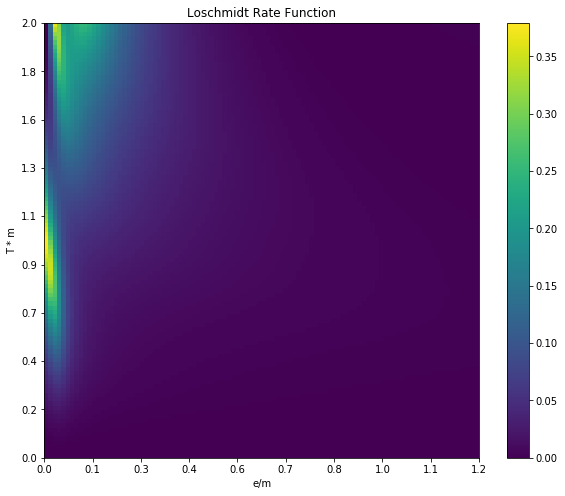

In [34]:
fig,ax = plt.subplots()
plt.ylabel("T * m")
plt.xlabel("e/m")
plt.title("Loschmidt Rate Function")

im = ax.imshow(Loschmidts)
ax.figure.colorbar(im,ax=ax)

x_tickcount=10
xticks = np.round(np.linspace(einit/minput,ef/minput,x_tickcount), 1)
ax.set_xticks(np.arange(x_tickcount))
ax.set_xticklabels(xticks)
ax.xaxis.set_major_locator(ticker.LinearLocator(x_tickcount))

y_tickcount=10
yticks=np.flip(np.round(np.linspace(0,Tf,y_tickcount), 1))
ax.set_yticks(np.arange(y_tickcount))
ax.set_yticklabels(yticks)
ax.yaxis.set_major_locator(ticker.LinearLocator(y_tickcount))



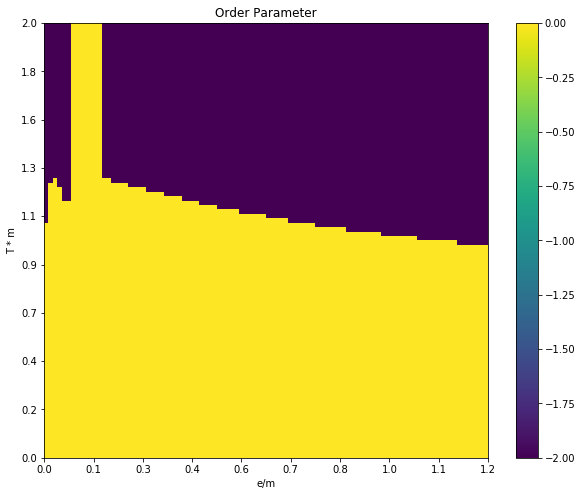

In [35]:
fig,ax = plt.subplots()
plt.ylabel("T * m")
plt.xlabel("e/m")
plt.title("Order Parameter")

im = ax.imshow(nuvals)
ax.figure.colorbar(im,ax=ax)

x_tickcount=10
xticks = np.round(np.linspace(einit/minput,ef/minput,x_tickcount), 1)
ax.set_xticks(np.arange(x_tickcount))
ax.set_xticklabels(xticks)
ax.xaxis.set_major_locator(ticker.LinearLocator(x_tickcount))

y_tickcount=10
yticks=np.flip(np.round(np.linspace(0,Tf,y_tickcount), 1))
ax.set_yticks(np.arange(y_tickcount))
ax.set_yticklabels(yticks)
ax.yaxis.set_major_locator(ticker.LinearLocator(y_tickcount))


In [36]:
acheck,bcheck=simulate(Tf,Ninput,0,minput,200)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
# T =  0.0
0.0	 -5.551115123125782e-17
0.0125	 3.048891924903918e-05
0.025	 0.0001219690467995098
0.037500000000000006	 0.00027448051308887105
0.05	 0.00048809027232954536
0.0625	 0.000762892207937682
0.07500000000000001	 0.0010990072805386279
0.08750000000000001	 0.0014965837189588802
0.1	 0.00195579725472945
0.1125	 0.0024768514007465162
0.125	 0.003059977774857613
0.1375	 0.003705436469262899
0.15000000000000002	 0.004413516466747815
0.1625	 0.005184536104891522
0.17500000000000002	 0.006018843589523835
0.1875	 0.006916817558838741
0.2	 0.007878867699706648
0.21250000000000002	 0.00890543541786484
0.225	 0.009996994563808464
0.23750000000000002	 0.011154052216345908
# T =  0.25
0.25	 0.012377149525926251
0.2625	 0.013666862619994

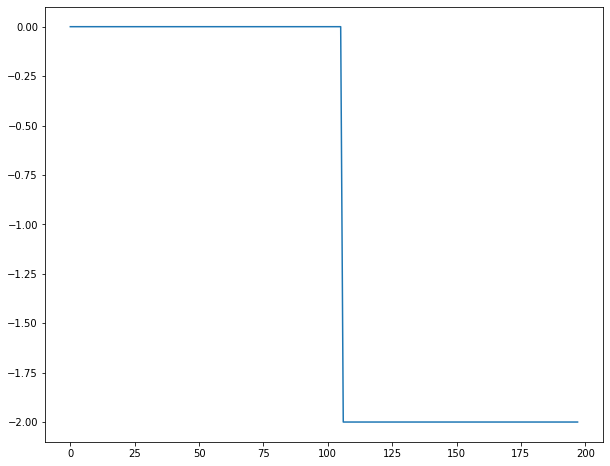

In [37]:
plt.plot(acheck)

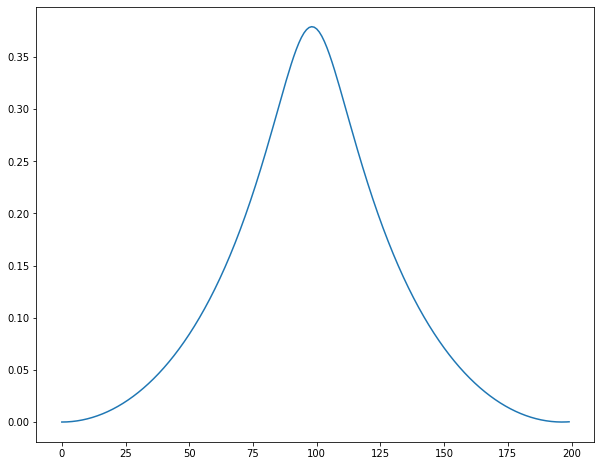

In [38]:
plt.plot(bcheck)